In [52]:
import yfinance as yf

btc = yf.download("BTC-USD", start="2020-08-01", end="2025-08-06", interval="1d")
eth = yf.download("ETH-USD", start="2020-08-01", end="2025-08-06", interval="1d")

# 保留常用列并保存
btc = btc[['Open','High','Low','Close','Volume']].rename(columns=str.lower).reset_index().rename(columns={'Date':'date'})
eth = eth[['Open','High','Low','Close','Volume']].rename(columns=str.lower).reset_index().rename(columns={'Date':'date'})

btc.to_csv("BTC_5y_daily.csv", index=False)
eth.to_csv("ETH_5y_daily.csv", index=False)
print("OK:", btc.shape, eth.shape)




/var/folders/tx/w6h_l95x6612vyhm8b7dd5tm0000gn/T/ipykernel_92061/441817203.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-08-01", end="2025-08-06", interval="1d")
[*********************100%***********************]  1 of 1 completed
/var/folders/tx/w6h_l95x6612vyhm8b7dd5tm0000gn/T/ipykernel_92061/441817203.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2020-08-01", end="2025-08-06", interval="1d")
[*********************100%***********************]  1 of 1 completed

OK: (1831, 6) (1831, 6)


In [53]:
import pandas as pd
import numpy as np

# ---- 0) 先把 date 变成 datetime，并排序（MultiIndex 访问法）----
btc[('date','')] = pd.to_datetime(btc[('date','')]).dt.floor('D')
eth[('date','')] = pd.to_datetime(eth[('date','')]).dt.floor('D')
btc = btc.sort_values(('date','')).reset_index(drop=True)
eth = eth.sort_values(('date','')).reset_index(drop=True)

# ---- 1) 统一日期（交集），保证两边同一组 trading days ----
common = np.intersect1d(btc[('date','')].values, eth[('date','')].values)
btc = btc[btc[('date','')].isin(common)].reset_index(drop=True)
eth = eth[eth[('date','')].isin(common)].reset_index(drop=True)

# ---- 2) 设定研究窗口（t），以及 t-1 / t-2 的窗口 ----
start_t = pd.Timestamp('2020-08-03')
end_t   = pd.Timestamp('2025-08-03')

mask_t   = (eth[('date','')] >= start_t) & (eth[('date','')] <= end_t)
mask_t1  = (eth[('date','')] >= start_t - pd.Timedelta(days=1)) & (eth[('date','')] <= end_t - pd.Timedelta(days=1))
mask_t2  = (eth[('date','')] >= start_t - pd.Timedelta(days=2)) & (eth[('date','')] <= end_t - pd.Timedelta(days=2))

# ---- 3) 逐列提取（注意：每次都 reset_index(drop=True)）----
# 目标 y = ETH_t
Eth_y_t   = eth.loc[mask_t,  ('close','eth-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)

# A 的四列：ETH_{t-1}, ETH_{t-2}, BTC_{t-1}, BTC_{t-2}
Eth_y_t_1 = eth.loc[mask_t1, ('close','eth-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)
Eth_y_t_2 = eth.loc[mask_t2, ('close','eth-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)

Btc_y_t_1 = btc.loc[mask_t1, ('close','btc-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)
Btc_y_t_2 = btc.loc[mask_t2, ('close','btc-usd')].reset_index(drop=True).to_numpy().reshape(-1,1)


A = np.hstack([Eth_y_t_1, Eth_y_t_2, Btc_y_t_1, Btc_y_t_2]).astype(float)
y = Eth_y_t.astype(float)

print("A shape:", A.shape, " y shape:", y.shape)
assert A.shape[0] == y.shape[0]



A shape: (1827, 4)  y shape: (1827, 1)


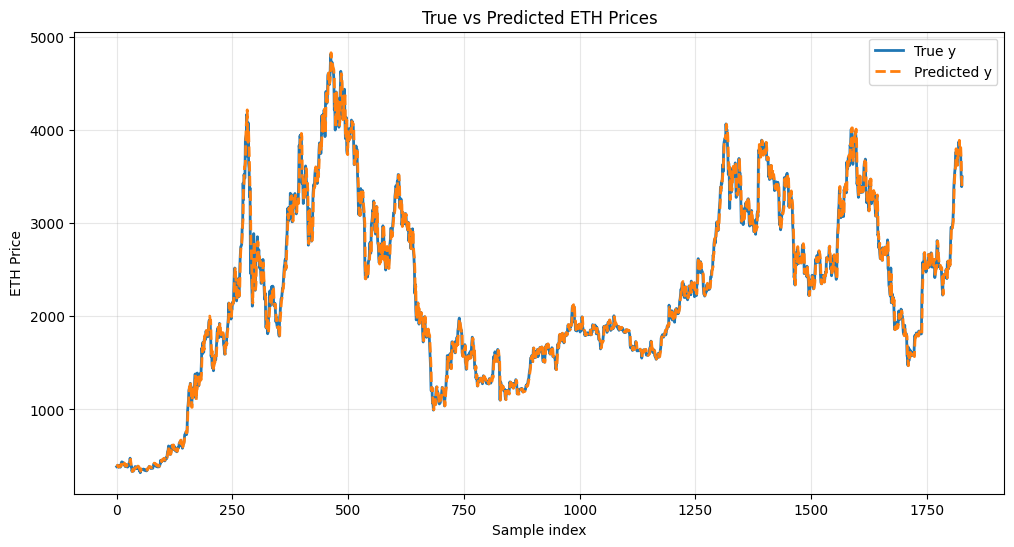

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# WEIGHT RLS

y_pred_list = []
beta = 0.99
P = np.identity(4)
theta = np.array([0,0,0,0]).reshape(-1,1) 

for row, y_t in zip(A, y): 
    row = row.reshape(-1, 1)    # (n, 1) 列向量
    newsample = row @ row.T  # (n, n) 外积
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P)/(beta+ row.T @ P @ row))
    predict = row.T @ theta
    y_pred_list.append(predict)
    

# 处理预测值 - 从array列表提取数值
y_pred_clean = [float(pred[0][0]) for pred in y_pred_list]

# 处理真实值 - 从二维数组变成一维
y_true_clean = y.flatten()

# 画图
plt.figure(figsize=(12, 6))
plt.plot(y_true_clean, label="True y", linewidth=2)
plt.plot(y_pred_clean, label="Predicted y", linestyle="--", linewidth=2)
plt.xlabel("Sample index")
plt.ylabel("ETH Price")
plt.legend()
plt.title("True vs Predicted ETH Prices")
plt.grid(True, alpha=0.3)
plt.show()






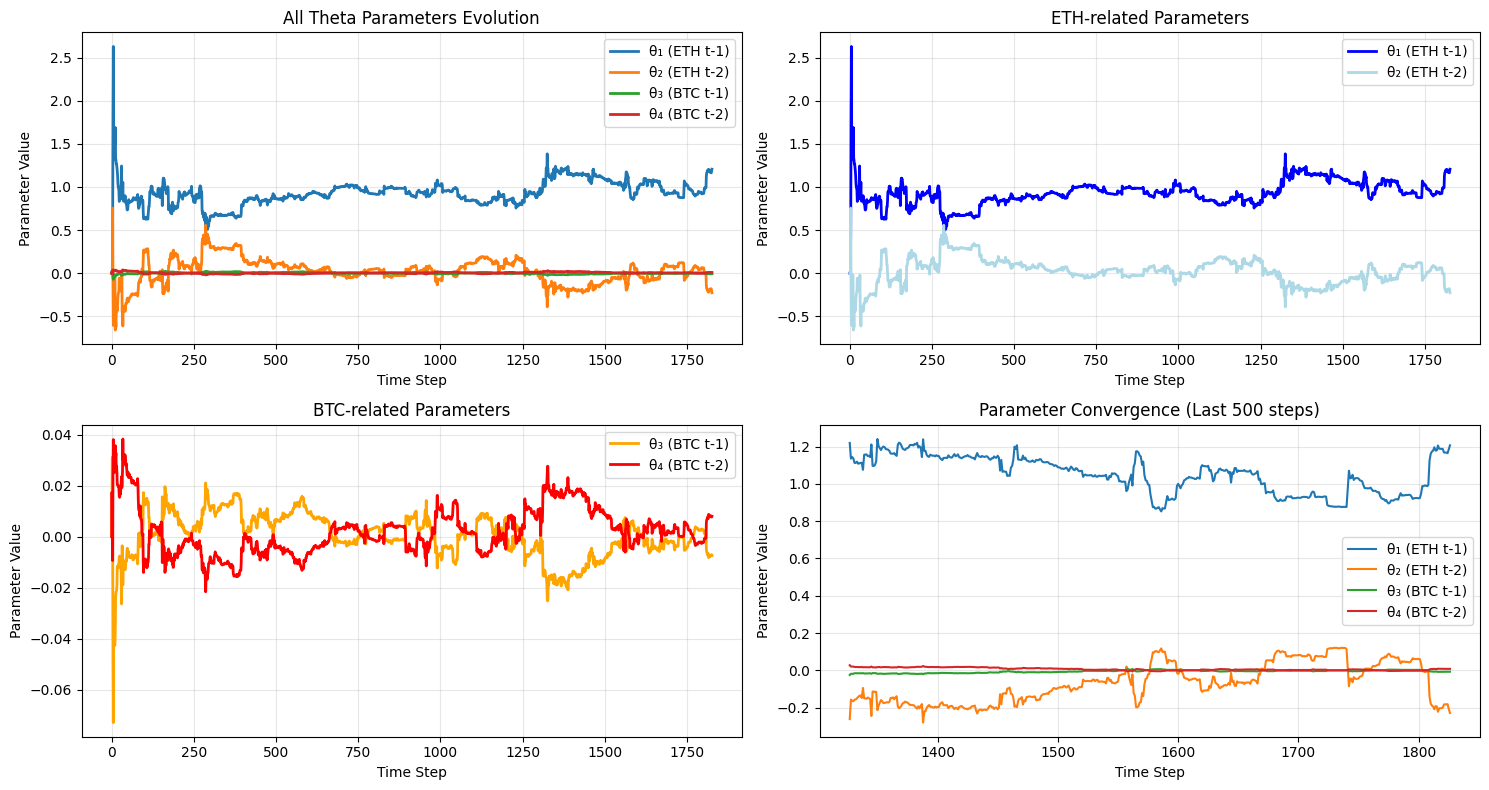

Final theta values:
θ₁ (ETH t-1): 1.186470
θ₂ (ETH t-2): -0.207154
θ₃ (BTC t-1): -0.006867
θ₄ (BTC t-2): 0.007498

Parameter change analysis:
ETH t-1: Range = 2.630743
ETH t-2: Range = 1.416253
BTC t-1: Range = 0.104123
BTC t-2: Range = 0.059940


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# WEIGHTED RLS - 记录theta变化
y_pred_list = []
theta_history = []  # 记录每一步的theta
beta = 0.99
P = np.identity(4)
theta = np.array([0, 0, 0, 0]).reshape(-1, 1)

for row, y_t in zip(A, y):
    row = row.reshape(-1, 1)    # (4, 1) 列向量
    newsample = row @ row.T     # (4, 4) 外积

    
    # 记录当前theta
    theta_history.append(theta)
    
    # 更新theta和P
    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P)/(beta + row.T @ P @ row))
    predict = (row.T @ theta)
    y_pred_list.append(predict)

# 转换为numpy数组便于绘图
theta_history = np.array(theta_history)

# 绘制theta变化图
plt.figure(figsize=(15, 8))

# 子图1: 所有theta参数在一起
plt.subplot(2, 2, 1)
plt.plot(theta_history[:, 0], label='θ₁ (ETH t-1)', linewidth=2)
plt.plot(theta_history[:, 1], label='θ₂ (ETH t-2)', linewidth=2)
plt.plot(theta_history[:, 2], label='θ₃ (BTC t-1)', linewidth=2)
plt.plot(theta_history[:, 3], label='θ₄ (BTC t-2)', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('All Theta Parameters Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2: ETH相关参数
plt.subplot(2, 2, 2)
plt.plot(theta_history[:, 0], label='θ₁ (ETH t-1)', color='blue', linewidth=2)
plt.plot(theta_history[:, 1], label='θ₂ (ETH t-2)', color='lightblue', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('ETH-related Parameters')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图3: BTC相关参数
plt.subplot(2, 2, 3)
plt.plot(theta_history[:, 2], label='θ₃ (BTC t-1)', color='orange', linewidth=2)
plt.plot(theta_history[:, 3], label='θ₄ (BTC t-2)', color='red', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('BTC-related Parameters')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图4: 参数收敛情况（最后500步）
plt.subplot(2, 2, 4)
if len(theta_history) > 500:
    start_idx = len(theta_history) - 500
    plt.plot(range(start_idx, len(theta_history)), theta_history[start_idx:, 0], label='θ₁ (ETH t-1)')
    plt.plot(range(start_idx, len(theta_history)), theta_history[start_idx:, 1], label='θ₂ (ETH t-2)')
    plt.plot(range(start_idx, len(theta_history)), theta_history[start_idx:, 2], label='θ₃ (BTC t-1)')
    plt.plot(range(start_idx, len(theta_history)), theta_history[start_idx:, 3], label='θ₄ (BTC t-2)')
else:
    plt.plot(theta_history[:, 0], label='θ₁ (ETH t-1)')
    plt.plot(theta_history[:, 1], label='θ₂ (ETH t-2)')
    plt.plot(theta_history[:, 2], label='θ₃ (BTC t-1)')
    plt.plot(theta_history[:, 3], label='θ₄ (BTC t-2)')
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('Parameter Convergence (Last 500 steps)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印最终参数值
print("Final theta values:")
print(f"θ₁ (ETH t-1): {theta[0,0]:.6f}")
print(f"θ₂ (ETH t-2): {theta[1,0]:.6f}")
print(f"θ₃ (BTC t-1): {theta[2,0]:.6f}")
print(f"θ₄ (BTC t-2): {theta[3,0]:.6f}")

# 分析参数变化幅度
print("\nParameter change analysis:")
for i, name in enumerate(['ETH t-1', 'ETH t-2', 'BTC t-1', 'BTC t-2']):
    param_range = np.max(theta_history[:, i]) - np.min(theta_history[:, i])
    print(f"{name}: Range = {param_range:.6f}")

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# contidional for P
log_cond_P = []  # 记录每一步的P的条件数
beta = 0.99
P = np.identity(4)
theta = np.array([0, 0, 0, 0]).reshape(-1, 1)

for row, y_t in zip(A, y):
    row = row.reshape(-1, 1)    # (4, 1) 列向量
    newsample = row @ row.T     # (4, 4) 外积

    theta = theta + (P @ row) * (y_t - row.T @ theta) / (beta + row.T @ P @ row)
    P = 1/beta * (P - (P @ newsample @ P)/(beta + row.T @ P @ row))
    predict = row.T @ theta
    
    cond_num = np.linalg.cond(P)

    log_cond_P.append(cond_num)  
print("Condition number:", log_cond_P)

Condition number: [263390091.16691074, 517191764.34466994, 777253493.2582552, 25466947.442874175, 14417894.770385658, 16908008.472019553, 8576023.645703742, 9829085.182271771, 11120620.858072685, 12178766.919617279, 12715280.965628544, 9087770.86799851, 6324901.587936252, 5146787.892893287, 5441498.464345737, 4742607.769534355, 5091690.595840763, 5039405.274686622, 5275351.044994745, 4685963.830339807, 4927426.46190729, 5134349.123257367, 5053599.716436507, 5102862.064133443, 5306432.167093427, 5528682.415670563, 5725628.661154799, 5899348.472663343, 5251364.773414128, 5401317.316392777, 4864929.6354512, 4396387.32924109, 4535661.732971548, 4414886.941290288, 3264030.5502371346, 3257214.8855315484, 3318411.199085012, 3398208.647951617, 3448549.610197522, 3473762.7958709714, 3556159.2046540105, 3598738.277430151, 3476341.160819643, 3511358.270856376, 3360039.7878018566, 3405540.506433482, 3157973.262337629, 3222635.76082771, 3275717.745293413, 3331626.289403696, 3398481.5060159145, 3473

ETH contribution: 0.4234, BTC contribution: 385.8718
ETH contribution: 0.4383, BTC contribution: 389.4372
ETH contribution: 0.4602, BTC contribution: 401.1304
ETH contribution: 0.4510, BTC contribution: 394.5109
ETH contribution: 0.4248, BTC contribution: 379.0880
ETH contribution: 0.4315, BTC contribution: 393.5559
ETH contribution: 0.4281, BTC contribution: 390.6923
ETH contribution: 0.4386, BTC contribution: 395.4490
ETH contribution: 0.4201, BTC contribution: 379.9640
ETH contribution: 0.4307, BTC contribution: 390.5934
ETH contribution: 0.4761, BTC contribution: 428.2657
ETH contribution: 0.5077, BTC contribution: 436.8901
ETH contribution: 0.5264, BTC contribution: 432.8285
ETH contribution: 0.5280, BTC contribution: 433.2586
ETH contribution: 0.5171, BTC contribution: 429.0142
ETH contribution: 0.4986, BTC contribution: 423.1707
ETH contribution: 0.4690, BTC contribution: 405.9948
ETH contribution: 0.4787, BTC contribution: 415.9610
ETH contribution: 0.4438, BTC contribution: 38

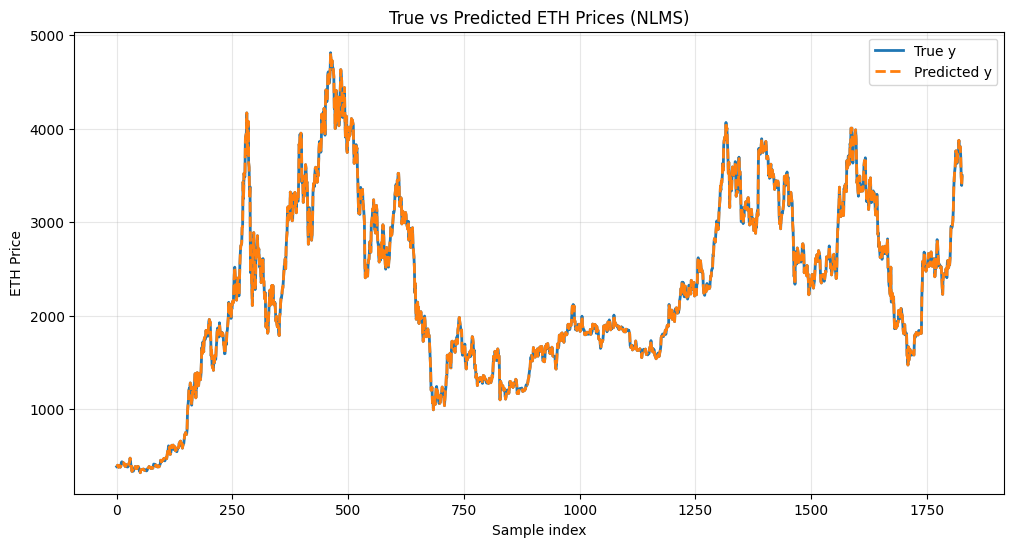

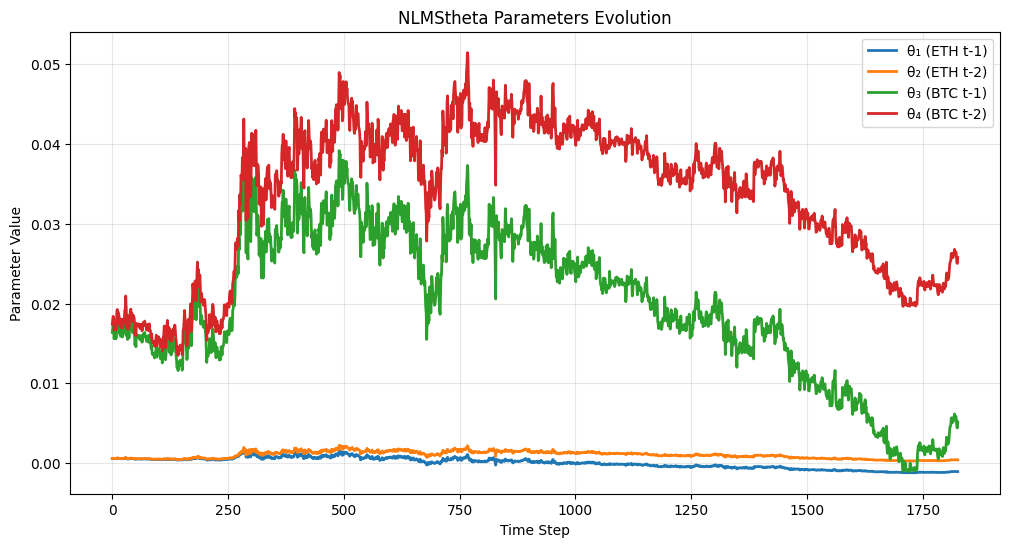

In [61]:
# NLMS
eta = 1.0
theta = np.array([0, 0, 0, 0]).reshape(-1, 1)
NLMStheta = []
NLMS_y_pred = []

for row, y_t in zip(A, y):
    row = row.reshape(-1, 1)   

    theta = theta + ((eta * row) * (y_t - row.T @ theta)) / (1 + eta * row.T @ row)
    NLMStheta.append(theta.flatten())
    predict = row.T @ theta

    # y prediction's contribution from ETH and BTC
    y_due_to_eth = row[:2].T @ theta[:2]
    y_due_to_btc = row[2:].T @ theta[2:]

    print(f"ETH contribution: {y_due_to_eth[0][0]:.4f}, BTC contribution: {y_due_to_btc[0][0]:.4f}")
    
    NLMS_y_pred.append(predict)

#Plot y pred vs y
plt.figure(figsize=(12, 6))
plt.plot(y.flatten(), label="True y", linewidth=2)
plt.plot([pred[0][0] for pred in NLMS_y_pred], label="Predicted y", linestyle="--", linewidth=2)
plt.xlabel("Sample index")
plt.ylabel("ETH Price")
plt.legend()
plt.title("True vs Predicted ETH Prices (NLMS)")
plt.grid(True, alpha=0.3)
plt.show()  

# Plot NLMStheta evolution
NLMStheta = np.array(NLMStheta)
plt.figure(figsize=(12, 6))
plt.plot(NLMStheta[:, 0], label='θ₁ (ETH t-1)', linewidth=2)
plt.plot(NLMStheta[:, 1], label='θ₂ (ETH t-2)', linewidth=2)
plt.plot(NLMStheta[:, 2], label='θ₃ (BTC t-1)', linewidth=2)
plt.plot(NLMStheta[:, 3], label='θ₄ (BTC t-2)', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('NLMStheta Parameters Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()






ETH contribution: 0.4234, BTC contribution: 385.8718
ETH contribution: 0.4383, BTC contribution: 389.4372
ETH contribution: 0.4602, BTC contribution: 401.1304
ETH contribution: 0.4510, BTC contribution: 394.5109
ETH contribution: 0.4248, BTC contribution: 379.0880
ETH contribution: 0.4315, BTC contribution: 393.5559
ETH contribution: 0.4281, BTC contribution: 390.6923
ETH contribution: 0.4386, BTC contribution: 395.4490
ETH contribution: 0.4201, BTC contribution: 379.9640
ETH contribution: 0.4307, BTC contribution: 390.5934
ETH contribution: 0.4761, BTC contribution: 428.2657
ETH contribution: 0.5077, BTC contribution: 436.8901
ETH contribution: 0.5264, BTC contribution: 432.8285
ETH contribution: 0.5280, BTC contribution: 433.2586
ETH contribution: 0.5171, BTC contribution: 429.0142
ETH contribution: 0.4986, BTC contribution: 423.1707
ETH contribution: 0.4690, BTC contribution: 405.9948
ETH contribution: 0.4787, BTC contribution: 415.9610
ETH contribution: 0.4438, BTC contribution: 38

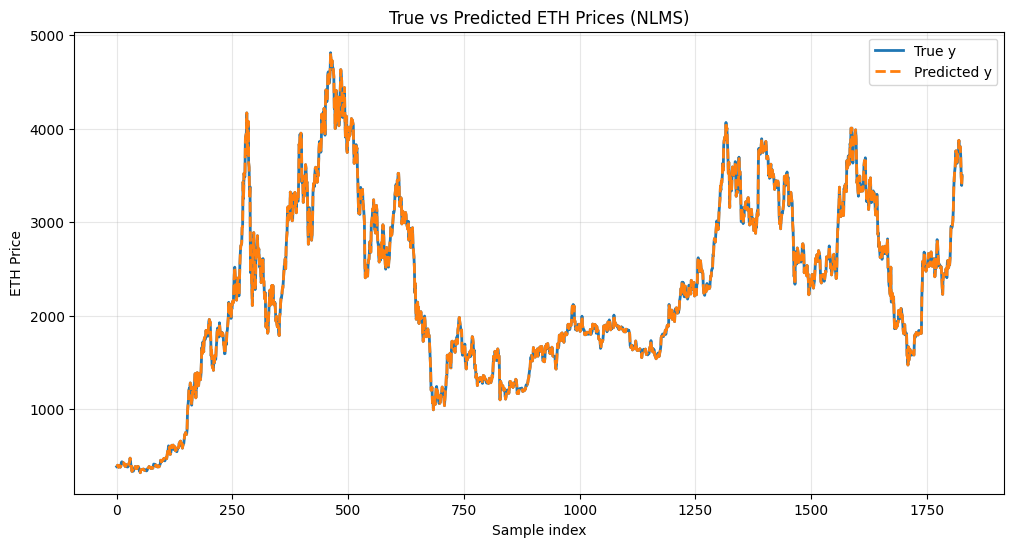

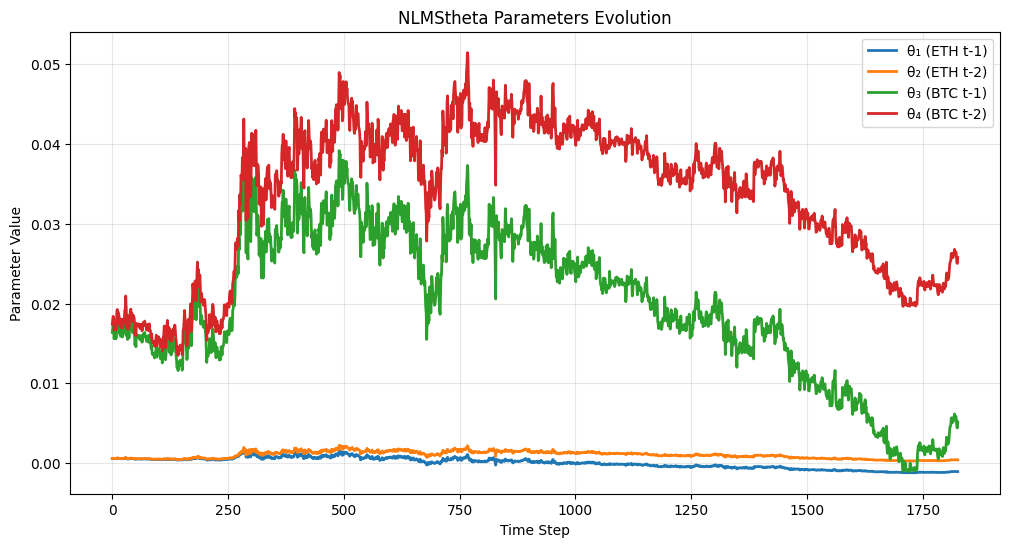

In [ ]:
# NLMS
eta = 1.0
theta = np.array([0, 0, 0, 0]).reshape(-1, 1)
NLMStheta = []
NLMS_y_pred = []

for row, y_t in zip(A, y):
    row = row.reshape(-1, 1)   

    theta = theta + ((eta * row) * (y_t - row.T @ theta)) / (1 + eta * row.T @ row)
    NLMStheta.append(theta.flatten())
    predict = row.T @ theta

    # y prediction's contribution from ETH and BTC
    y_due_to_eth = row[:2].T @ theta[:2]
    y_due_to_btc = row[2:].T @ theta[2:]

    print(f"ETH contribution: {y_due_to_eth[0][0]:.4f}, BTC contribution: {y_due_to_btc[0][0]:.4f}")
    
    NLMS_y_pred.append(predict)

#Plot y pred vs y
plt.figure(figsize=(12, 6))
plt.plot(y.flatten(), label="True y", linewidth=2)
plt.plot([pred[0][0] for pred in NLMS_y_pred], label="Predicted y", linestyle="--", linewidth=2)
plt.xlabel("Sample index")
plt.ylabel("ETH Price")
plt.legend()
plt.title("True vs Predicted ETH Prices (NLMS)")
plt.grid(True, alpha=0.3)
plt.show()  

# Plot NLMStheta evolution
NLMStheta = np.array(NLMStheta)
plt.figure(figsize=(12, 6))
plt.plot(NLMStheta[:, 0], label='θ₁ (ETH t-1)', linewidth=2)
plt.plot(NLMStheta[:, 1], label='θ₂ (ETH t-2)', linewidth=2)
plt.plot(NLMStheta[:, 2], label='θ₃ (BTC t-1)', linewidth=2)
plt.plot(NLMStheta[:, 3], label='θ₄ (BTC t-2)', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Parameter Value')
plt.title('NLMStheta Parameters Evolution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()




